## Calc de gradient vector for a cavity. 

### Desplazamientos entre -2 y 2

In [1]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/german/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/german/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


In [2]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [3]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [4]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [5]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [6]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [7]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
prt_name = "1hvr_apo"
pdb_filename = string("/home/german/labo/16/exs/cavities/bu/avg_", prt_name, ".pdb")
pdb_pdb = read(pdb_filename, PDBFile, group="ATOM");

# Obtengo el número de átomos de c/ residuo
for i=1:length(pdb_pdb)
    push!(natom_res, length(pdb_pdb[i]))
end
shift!(natom_res)

# Obtengo el nro de aa's
aa = length(pdb_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn = Array{Float64}(aa3-6);
vol_ndd = Array{Float64, 2}(0, 2);
factorr = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_prt, evals_prt = read_ptraj_modes("/home/german/labo/16/exs/run/1hvr_apo/pca/modes_1hvr_apo", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/exs/cavities/1hvr_apo/"
# Archivos de config de ANA
conf_prt_whole = "/home/german/labo/16/exs/cavities/bu/1hvr_apo.cfg"

"/home/german/labo/16/exs/cavities/bu/1hvr_apo.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [8]:
constant = 3
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_prt[i*3-2, j]
            modo_sum[i, 2] = modes_prt[i*3-1, j]
            modo_sum[i, 3] = modes_prt[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factorr[j] = magnitude * constant * 1/evals_prt[j]
# Modifico las coordenadas
        hvr_apo_atom_xyz = coordinatesmatrix(pdb_pdb)
        new_hvr_apo_atom_xyz = hvr_apo_atom_xyz + modo_sum .* factorr[j];
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb_pdb = change_coordinates(pdb_pdb, new_hvr_apo_atom_xyz)
# Escribo el nuevo .pdb
        pdb_hvr_apo = string(files_template, displacement, "/", "mod", j, "_", displacement, "_hvr_apo.pdb")
        write(pdb_hvr_apo, new_pdb_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal, largo y whole p/ los 2 sets de 345 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 4 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal, largo y whole a c/u de los elementos de los 8 vectores y así obtengo 2 sets de 4 vectores gradiente en base de coordenadas cartesianas.

In [9]:
# Obtengo los vectores de volúmenes p/ los 4 huecos con desplazamientos negativos y positivos
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Preparo variables
    ndd_input_filename = string(files_template, displacement, "/inndd_", prt_name, "_", displacement)
    ndd_output_filename = string(files_template, displacement, "/outndd_", prt_name, "_", displacement)
    
    # WHOLE
    global vol_ndd = symbol("vol_ndd_whole_", displacement)
    global gdte_ndd = symbol("gdte_ndd_whole_", displacement)  
    # Calculo el pocket        
    run(`ANA $pdb_filename -c $conf_prt_whole -I $ndd_input_filename -O $ndd_output_filename`);
    # Leo
    ndd_output = readdlm(ndd_output_filename, header=true)[1][:, 2]
    @eval ($vol_ndd = $ndd_output)
    @eval ($gdte_ndd = $ndd_output .- parse(Float64, readall(`ANA $pdb_filename -c $conf_prt_whole`)))
end

Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


1085.38


Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 
Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


1085.38


Chemfiles warning: Unknown PDB record: TER    1562      PHE    99 


### Finalmente, obtengo el vector gradiente

In [10]:
# Ahora obtengo el gradiente entre los desplazamientos negativo y positivo.
gdte_whole = (vol_ndd_whole_d2 - vol_ndd_whole_d_2) .* evals_prt;

# Los vectores tienen el (delta)volumen. Puedo elegir normalizarlos o dividirlos por el desplazamiento
# o lo q sea. Los normalizo
gdte_whole = gdte_whole / norm(gdte_whole);

# ------------------------------------------------------------------------------------------------------------

## 2 series de 5 tipos de histogramas:

## A: todos los modos
#### Histograma de conteo de modos * ∇Volumen según frecuencia
#### Histograma de conteo de modos * ∇Volumen según colectividad
#### Histograma de conteo de modos * ∇Volumen según colectividad de modos recortados
#### Histograma de conteo de modos * ∇Volumen según pnumber
#### Histograma de conteo de modos * ∇Volumen según pnumber de modos recortados

## B: los 1eros "pnumber" modos
#### Histograma de conteo de modos * ∇Volumen según frecuencia
#### Histograma de conteo de modos * ∇Volumen según colectividad
#### Histograma de conteo de modos * ∇Volumen según colectividad de modos recortados
#### Histograma de conteo de modos * ∇Volumen según pnumber
#### Histograma de conteo de modos * ∇Volumen según pnumber de modos recortados

### Determino los aminoácidos de las paredes del hueco, estableciendo un mínimo en el valor de su elemento correspondiente en el vector gradiente. 0.1 suele ser un buen mínimo.

In [40]:
modes_prt_1 = Array{Float64}(aa3, aa3-6);
# Arreglo el pbma de 0
for i=1:size(modes_prt)[1]
    for j=1:size(modes_prt)[2]
        if modes_prt[i, j] == 0
            modes_prt_1[i, j] = 0.00001
        else
            modes_prt_1[i, j] = modes_prt[i, j]
        end
    end
end

# Paso a cartesianas y luego a aminoácidos
aa_gdte_whole = tognm(modes_prt*gdte_whole)

# 2 plots p/ decidir a ojo
plot(DataFrame(delta=sort(aa_gdte_whole, rev=true)), Geom.line, y="delta",
Guide.xticks(ticks=collect(1:1:25)), Coord.cartesian(xmin=1, xmax=25))

plot(DataFrame(delta=aa_gdte_whole), Geom.bar, y="delta",
Guide.xticks(ticks=collect(1:10:110)), Coord.cartesian(xmin=1, xmax=110))

mask_gdte_whole = aa_gdte_whole .>= 0.1;
indices_gdte_whole = find(x-> x==true, mask_gdte_whole)
wall_whole_nres = length(indices_gdte_whole)
println(indices_gdte_whole)

# Tengo los indices de los aa's del hueco. Ahora tengo q pasarlos a índices de elementos de modos
modeind_gdte_whole = reshape(mapslices(x -> [x*3-2; x*3-1; x*3], transpose(indices_gdte_whole), 1),
    3*wall_whole_nres)
println("\n gradient vector wall residues indices:\n", modeind_gdte_whole)

# Subsetteo los modos p/ aislar los componentes de los aa's del hueco
modes_prt_1_whole = modes_prt_1[modeind_gdte_whole, :];
modes_prt_1_whole_nonnorm = modes_prt_1_whole
modes_prt_1_whole = mapslices(x -> x/norm(x), modes_prt_1_whole, 1);

[8,25,28,32,47,48,49,50,56,80,81,84,107,126,127,128,129,131,146,147,148,149,155,179,180,183]

 gradient vector wall residues indices:
[22,23,24,73,74,75,82,83,84,94,95,96,139,140,141,142,143,144,145,146,147,148,149,150,166,167,168,238,239,240,241,242,243,250,251,252,319,320,321,376,377,378,379,380,381,382,383,384,385,386,387,391,392,393,436,437,438,439,440,441,442,443,444,445,446,447,463,464,465,535,536,537,538,539,540,547,548,549]


----------------------

# A: todos los modos

### Frecuencia

In [206]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10% 
top_freq_a = maximum(evals_prt) * 1.1
bins_freq_a = collect(0:25:top_freq_a)
unos_freq_a = repeat([1.0], inner=[length(evals_prt)])

# Histograma no ponderado
mode_freq_his, mode_freq_bins = WeightedHist(evals_prt, bins_freq_a, unos_freq_a, true);
df_mode_freq_his = DataFrame(Probability = mode_freq_his, Frequency = mode_freq_bins);

# Histograma ponderado
mode_freq_Whis, mode_freq_Wbins = WeightedHist(evals_prt, bins_freq_a, abs(gdte_whole), true);
df_mode_freq_Whis = DataFrame(Probability = mode_freq_Whis, Frequency = mode_freq_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens = mode_freq_Whis ./ mode_freq_his
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens[isnan(mode_freq_Whis_state_dens)] = 0
# Turn to density
mode_freq_Whis_state_dens = mode_freq_Whis_state_dens ./ sum(mode_freq_Whis_state_dens)
df_mode_freq_Whis_state_dens = DataFrame(Probability = mode_freq_Whis_state_dens, Frequency = mode_freq_Wbins);

### Colectividad
Antes de calcular colectividad le pongo 0.00001 a los elementos nulos. Así no me da NaN. 

Calculo colectividad de c/ modo usando a ecu (4) de SANEJOUAND; Conformational change of proteins arising from normal mode calculations

In [42]:
# Colectividad de modos enteros
κ = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1, 1), 1)) ./
    size(modes_prt)[1]
κ = reshape(κ, size(modes_prt)[2])

# Colectividad de modos recortados
κ_whole = exp(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log(x.^2), modes_prt_1_whole, 1), 1)) ./
    size(modes_prt_1_whole)[1]
κ_whole = reshape(κ_whole, size(modes_prt_1_whole)[2]);

In [43]:
# Los bins van de 0 al valor del elemento más alto del gradiente + 10%
top_κ_a = maximum(κ) * 1.1
top_κ_whole_a = maximum(κ_whole) * 1.1
bins_κ_a = collect(0:0.01:top_κ_a)
bins_κ_whole_a = collect(0:0.01:top_κ_whole_a)
unos_κ = repeat([1.0], inner=[length(κ)])

# Colectividad de modos enteros

# Histograma no ponderado
mode_κ_his, mode_κ_bins = WeightedHist(κ, bins_κ_a, unos_κ, true);
df_mode_κ_his = DataFrame(Probability = mode_κ_his, Collectivity = mode_κ_bins);

# Histograma por colectividad de modo
mode_κ_Whis, mode_κ_Wbins = WeightedHist(κ, bins_κ_a, abs(gdte_whole), true);
df_mode_κ_Whis = DataFrame(Probability = mode_κ_Whis, Collectivity = mode_κ_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_Whis_state_dens = mode_κ_Whis ./ mode_κ_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_Whis_state_dens[isnan(mode_κ_Whis_state_dens)] = 0
# Turn to density
mode_κ_Whis_state_dens = mode_κ_Whis_state_dens ./ sum(mode_κ_Whis_state_dens)
df_mode_κ_Whis_state_dens = DataFrame(Probability = mode_κ_Whis_state_dens,
    Collectivity = mode_κ_Wbins);


# Colectividad de modos recortados

# Histograma no ponderado
mode_κ_whole_his, mode_κ_whole_bins = WeightedHist(κ_whole, bins_κ_whole_a, unos_κ, true);
df_mode_κ_whole_his = DataFrame(Probability = mode_κ_whole_his, Collectivity = mode_κ_whole_bins);

# Histograma por colectividad de modo
mode_κ_whole_Whis, mode_κ_whole_Wbins = WeightedHist(κ_whole, bins_κ_whole_a, abs(gdte_whole), true);
df_mode_κ_whole_Whis = DataFrame(Probability = mode_κ_whole_Whis, Collectivity = mode_κ_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_whole_Whis_state_dens = mode_κ_whole_Whis ./ mode_κ_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_whole_Whis_state_dens[isnan(mode_κ_whole_Whis_state_dens)] = 0
# Turn to density
mode_κ_whole_Whis_state_dens = mode_κ_whole_Whis_state_dens ./ sum(mode_κ_whole_Whis_state_dens)
df_mode_κ_whole_Whis_state_dens = DataFrame(Probability = mode_κ_whole_Whis_state_dens,
    Collectivity = mode_κ_whole_Wbins);

### Pnumber

In [44]:
# Pnumber de modos enteros
modes_prt_gnm = mapslices(x->tognm(x), modes_prt, 1)
pnum_modes_prt = transpose((mapslices(x->sum(x), (modes_prt_gnm .^ 4), 1)) .^ -1)[:, 1]
df_gdte_pnum = DataFrame(∇Volume = abs(gdte_whole), Pnumber = pnum_modes_prt)
# Pnumber relativo (pn)
pn_modes_prt = pnum_modes_prt ./ length(pdb_pdb);

# Pnumber de modos recortados
modes_prt_1_whole_gnm = mapslices(x->tognm(x), modes_prt_1_whole, 1)
pnum_modes_prt_whole = transpose((mapslices(x->sum(x), (modes_prt_1_whole_gnm .^ 4), 1)) .^ -1)[:, 1]
df_gdte_pnum_whole = DataFrame(∇Volume = abs(gdte_whole), Pnumber = pnum_modes_prt)
# Pnumber relativo (pn)
pn_modes_prt_whole = pnum_modes_prt_whole ./ length(indices_gdte_whole);

In [45]:
# Los bins van de 0 al pnumber más alto + 10%
top_pn_a = maximum(pn_modes_prt) * 1.1
top_pn_whole_a = maximum(pn_modes_prt_whole) * 1.1
bins_pn_a = collect(0:0.01:top_pn_a)
bins_pn_whole_a = collect(0:0.01:top_pn_whole_a)
unos_pn = repeat([1.0], inner=[length(pn_modes_prt)])

# Pnumber de modos enteros

# Histograma no ponderado
mode_pn_his, mode_pn_bins = WeightedHist(pn_modes_prt, bins_pn_a, unos_pn, true);
df_mode_pn_his = DataFrame(Probability = mode_pn_his, Pnumber = mode_pn_bins);

# Histograma por colectividad de modo
mode_pn_Whis, mode_pn_Wbins = WeightedHist(pn_modes_prt, bins_pn_a, abs(gdte_whole), true);
df_mode_pn_Whis = DataFrame(Probability = mode_pn_Whis, Pnumber = mode_pn_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_Whis_state_dens = mode_pn_Whis ./ mode_pn_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_Whis_state_dens[isnan(mode_pn_Whis_state_dens)] = 0
# Turn to density
mode_pn_Whis_state_dens = mode_pn_Whis_state_dens ./ sum(mode_pn_Whis_state_dens)
df_mode_pn_Whis_state_dens = DataFrame(Probability = mode_pn_Whis_state_dens,
    Pnumber = mode_pn_Wbins);


# Pnumber de modos recortados

# Histograma no ponderado
mode_pn_whole_his, mode_pn_whole_bins = WeightedHist(pn_modes_prt_whole, bins_pn_whole_a, unos_pn, true);
df_mode_pn_whole_his = DataFrame(Probability = mode_pn_whole_his, Pnumber = mode_pn_whole_bins);

# Histograma por colectividad de modo
mode_pn_whole_Whis, mode_pn_whole_Wbins = WeightedHist(pn_modes_prt_whole, bins_pn_whole_a, abs(gdte_whole), true);
df_mode_pn_whole_Whis = DataFrame(Probability = mode_pn_whole_Whis, Pnumber = mode_pn_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis ./ mode_pn_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_whole_Whis_state_dens[isnan(mode_pn_whole_Whis_state_dens)] = 0
# Turn to density
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis_state_dens ./ sum(mode_pn_whole_Whis_state_dens)
df_mode_pn_whole_Whis_state_dens = DataFrame(Probability = mode_pn_whole_Whis_state_dens,
    Pnumber = mode_pn_whole_Wbins);

## Gráficos de A: todos los modos

### Según frecuencia

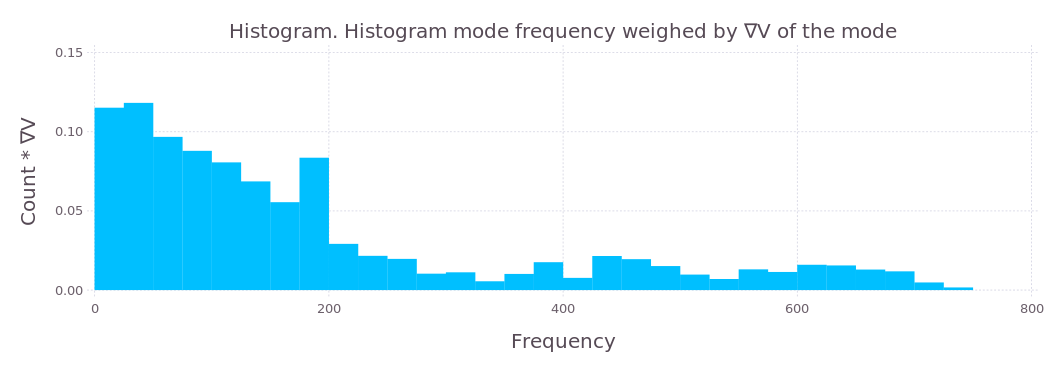

In [46]:
pdf_mode_freq_Whis = plot(df_mode_freq_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Según colectividad

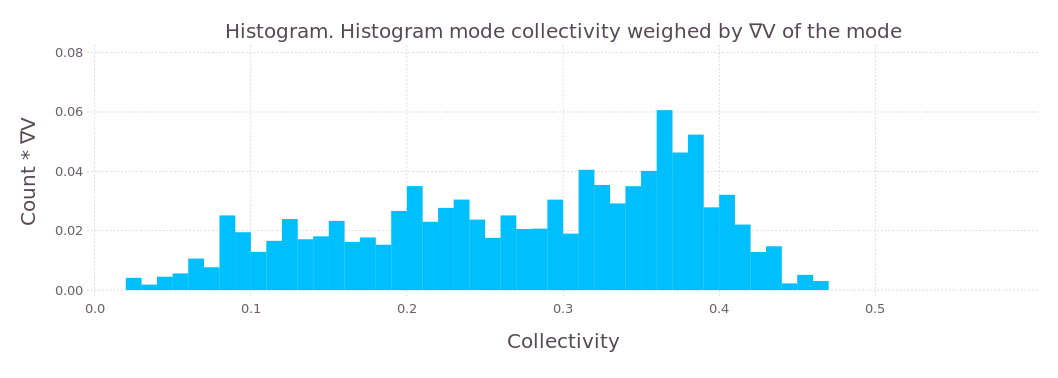

In [47]:
pdf_mode_κ_Whis = plot(df_mode_κ_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode collectivity weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

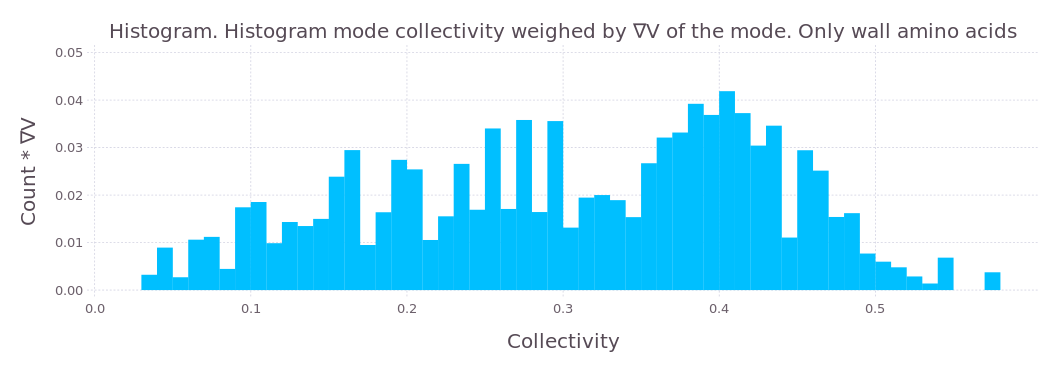

In [48]:
pdf_mode_κ_whole_Whis = plot(df_mode_κ_whole_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode collectivity weighed by ∇V of the mode. Only wall amino acids"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Según Pnumber

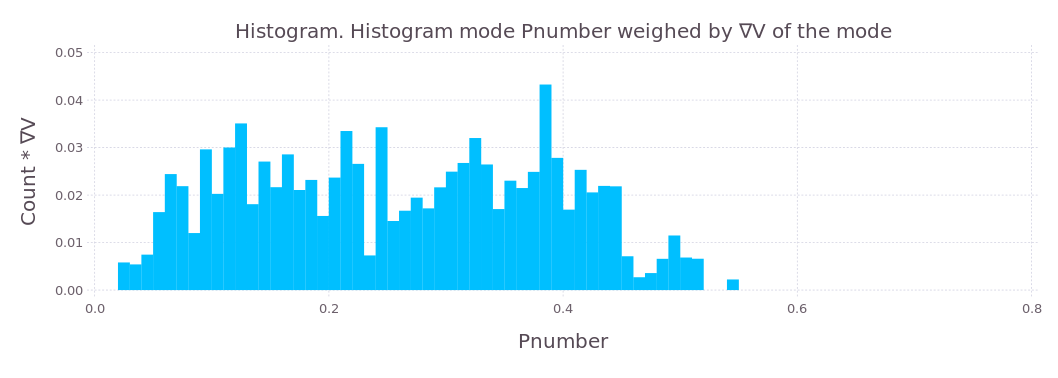

In [63]:
pdf_mode_pn_Whis = plot(df_mode_pn_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode Pnumber weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

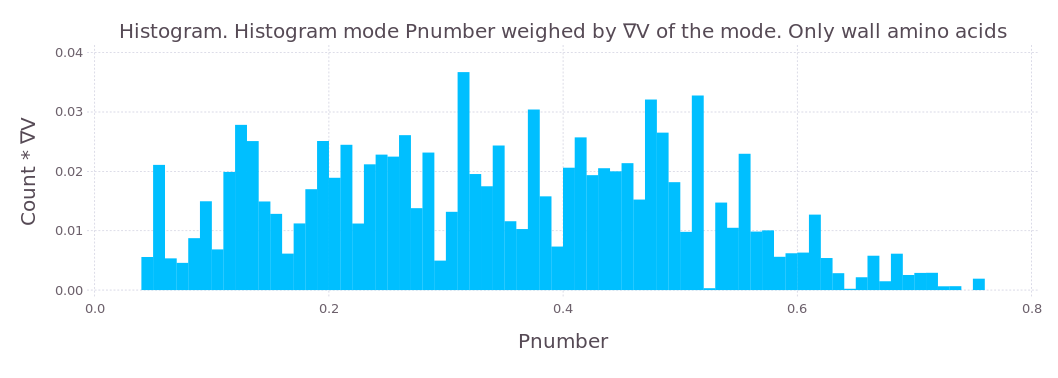

In [64]:
pdf_mode_pn_whole_Whis = plot(df_mode_pn_whole_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode Pnumber weighed by ∇V of the mode. Only wall amino acids"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

# B: los 1eros "pnumber" modos

### Me quedo con los Pnumber modos, elementos de gradiente, frecuencias, colectividades y Pnumber de c/ modo

In [51]:
# Obtengo el pnumber
pnumber_gdte = convert(Int64, round(sum(gdte_whole .^ 4) .^ -1))
# Obtengo los índices de los 1eros "pnumber" modos
indices_pnum_modes = sortperm(abs(gdte_whole), rev=true)[1:pnumber_gdte]
indices_pnum_modes = sort(indices_pnum_modes)

# Ahora recorto los modos, el gradiente, las frecuencias, las colectividades, los pnumber

# Me quedo con los "pnumber" modos. Uso los modos q ya fueron rellenados
modes_prt_pnum = modes_prt_1[:, indices_pnum_modes];
# Me quedo con los ∇Volumen de los "pnumber" modos
gdte_whole_pnum = gdte_whole[indices_pnum_modes];
# Me quedo con las frequencias de los "pnumber" modos
evals_prt_pnum = evals_prt[indices_pnum_modes]
# Me quedo con las colectividades "pnumber" modos
κ_pnum = κ[indices_pnum_modes]
κ_whole_pnum = κ_whole[indices_pnum_modes]
# Me quedo con los pnumber (de aa's) de los "pnumber" modos
pn_modes_prt_pnum = pn_modes_prt[indices_pnum_modes];
pn_modes_prt_whole_pnum = pn_modes_prt_whole[indices_pnum_modes];

### Según frecuencia

In [52]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_freq_Whis

# Los bins van de 0 a la fqcia más alta + 10%
top_freq = maximum(evals_prt_pnum) * 1.1
bins_freq = collect(0:25:top_freq)
unos_freq = repeat([1.0], inner=[length(evals_prt_pnum)])

# Histograma no ponderado
mode_freq_his, mode_freq_bins = WeightedHist(evals_prt_pnum, bins_freq, unos_freq, true);
df_mode_freq_pnum_his = DataFrame(Probability = mode_freq_his, Frequency = mode_freq_bins);

# Histograma ponderado
mode_freq_Whis, mode_freq_Wbins = WeightedHist(evals_prt_pnum, bins_freq, abs(gdte_whole_pnum), true);
df_mode_freq_pnum_Whis = DataFrame(Probability = mode_freq_Whis, Frequency = mode_freq_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_freq_Whis_state_dens = mode_freq_Whis ./ mode_freq_his
# Fix some NaNs caused by "divide by zero" error
mode_freq_Whis_state_dens[isnan(mode_freq_Whis_state_dens)] = 0
# Turn to density
mode_freq_Whis_state_dens = mode_freq_Whis_state_dens ./ sum(mode_freq_Whis_state_dens)
df_mode_freq_pnum_Whis_state_dens = DataFrame(Probability = mode_freq_Whis_state_dens, Frequency = mode_freq_Wbins);

### Según colectividad

In [53]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_κ_pnum_his

# Los bins van de 0 al valor del elemento más alto del gradiente + 10%
top_κ_pnum = maximum(κ_pnum) * 1.1
top_κ_whole_pnum = maximum(κ_whole_pnum) * 1.1 
bins_κ_pnum = collect(0:0.01:top_κ_pnum)
bins_κ_whole_pnum = collect(0:0.01:top_κ_whole_pnum)
unos_κ_pnum = repeat([1.0], inner=[length(κ_pnum)])

# Colectividad de modos enteros

# Histograma no ponderado
mode_κ_pnum_his, mode_κ_pnum_bins = WeightedHist(κ_pnum, bins_κ_pnum, unos_κ_pnum, true);
df_mode_κ_pnum_his = DataFrame(Probability = mode_κ_pnum_his, Collectivity = mode_κ_pnum_bins);

# Histograma por colectividad de modo
mode_κ_pnum_Whis, mode_κ_pnum_Wbins = WeightedHist(κ_pnum, bins_κ_pnum, abs(gdte_whole_pnum), true);
df_mode_κ_pnum_Whis = DataFrame(Probability = mode_κ_pnum_Whis, Collectivity = mode_κ_pnum_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_pnum_Whis_state_dens = mode_κ_pnum_Whis ./ mode_κ_pnum_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_pnum_Whis_state_dens[isnan(mode_κ_pnum_Whis_state_dens)] = 0
# Turn to density
mode_κ_pnum_Whis_state_dens = mode_κ_pnum_Whis_state_dens ./ sum(mode_κ_pnum_Whis_state_dens)
df_mode_κ_pnum_Whis_state_dens = DataFrame(Probability = mode_κ_pnum_Whis_state_dens,
    Collectivity = mode_κ_pnum_Wbins);


# Colectividad de modos recortados

# Histograma no ponderado
mode_κ_whole_pnum_his, mode_κ_whole_pnum_bins = WeightedHist(κ_whole_pnum, bins_κ_whole_pnum, unos_κ_pnum, true); 
df_mode_κ_whole_pnum_his = DataFrame(Probability = mode_κ_whole_pnum_his, Collectivity = mode_κ_whole_pnum_bins);

# Histograma por colectividad de modo
mode_κ_whole_pnum_Whis, mode_κ_whole_pnum_Wbins = WeightedHist(κ_whole_pnum, bins_κ_whole_pnum, abs(gdte_whole_pnum), true);
df_mode_κ_whole_pnum_Whis = DataFrame(Probability = mode_κ_whole_pnum_Whis, Collectivity = mode_κ_whole_pnum_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_κ_whole_pnum_Whis_state_dens = mode_κ_whole_pnum_Whis ./ mode_κ_whole_pnum_his
# Fix some NaNs caused by "divide by zero" error
mode_κ_whole_pnum_Whis_state_dens[isnan(mode_κ_whole_pnum_Whis_state_dens)] = 0
# Turn to density
mode_κ_whole_pnum_Whis_state_dens = mode_κ_whole_pnum_Whis_state_dens ./ sum(mode_κ_whole_pnum_Whis_state_dens)
df_mode_κ_whole_pnum_Whis_state_dens = DataFrame(Probability = mode_κ_whole_pnum_Whis_state_dens,
    Collectivity = mode_κ_whole_pnum_Wbins);

### Según Pnumber

In [68]:
# Calculo 3 histogramas por las dudas, pero solo gráfico  df_mode_pn_pnum_his

# Los bins van de 0 al pnumber más alto + 10%
top_pn_a = maximum(pn_modes_prt_pnum) * 1.1
top_pn_whole_a = maximum(pn_modes_prt_whole_pnum) * 1.1
bins_pn_a = collect(0:0.01:top_pn_a)
bins_pn_whole_a = collect(0:0.01:top_pn_whole_a)
unos_pn = repeat([1.0], inner=[length(pn_modes_prt_pnum)])

# Pnumber de modos enteros

# Histograma no ponderado
mode_pn_his, mode_pn_bins = WeightedHist(pn_modes_prt_pnum, bins_pn_a, unos_pn, true);
df_mode_pn_pnum_his = DataFrame(Probability = mode_pn_his, Pnumber = mode_pn_bins);

# Histograma por colectividad de modo
mode_pn_Whis, mode_pn_Wbins = WeightedHist(pn_modes_prt_pnum, bins_pn_a, abs(gdte_whole_pnum), true);
df_mode_pn_pnum_Whis = DataFrame(Probability = mode_pn_Whis, Pnumber = mode_pn_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_Whis_state_dens = mode_pn_Whis ./ mode_pn_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_Whis_state_dens[isnan(mode_pn_Whis_state_dens)] = 0
# Turn to density
mode_pn_Whis_state_dens = mode_pn_Whis_state_dens ./ sum(mode_pn_Whis_state_dens)
df_mode_pn_pnum_Whis_state_dens = DataFrame(Probability = mode_pn_Whis_state_dens,
    Pnumber = mode_pn_Wbins);


# Pnumber de modos recortados

# Histograma no ponderado
mode_pn_whole_his, mode_pn_whole_bins = WeightedHist(pn_modes_prt_whole_pnum, bins_pn_whole_a, unos_pn, true);
df_mode_pn_whole_pnum_his = DataFrame(Probability = mode_pn_whole_his, Pnumber = mode_pn_whole_bins);

# Histograma por colectividad de modo
mode_pn_whole_Whis, mode_pn_whole_Wbins = WeightedHist(pn_modes_prt_whole_pnum, bins_pn_whole_a, abs(gdte_whole_pnum), true);
df_mode_pn_whole_pnum_Whis = DataFrame(Probability = mode_pn_whole_Whis, Pnumber = mode_pn_whole_Wbins);

# Histograma ponderado y dividido por densidad de estados
mode_pn_whole_Whis_state_dens = mode_pn_whole_Whis ./ mode_pn_whole_his
# Fix some NaNs caused by "divide by zero" error
mode_pn_whole_Whis_state_dens[isnan(mode_pn_whole_Whis_state_dens)] = 0
# Turn to density
mode_pn_whole_pnum_Whis_state_dens = mode_pn_whole_Whis_state_dens ./ sum(mode_pn_whole_Whis_state_dens)
df_mode_pnwhole_Whis_state_dens = DataFrame(Probability = mode_pn_whole_Whis_state_dens,
    Pnumber = mode_pn_whole_Wbins);

## Gráficos de B: los 1eros "pnumber" modos

### Según frecuencia

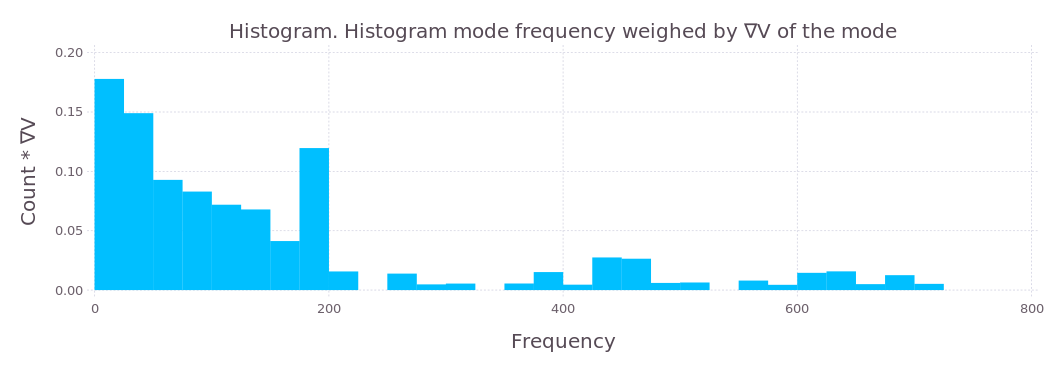

In [55]:
pdf_mode_freq_pnum_Whis = plot(df_mode_freq_pnum_Whis, x="Frequency", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Según colectividad

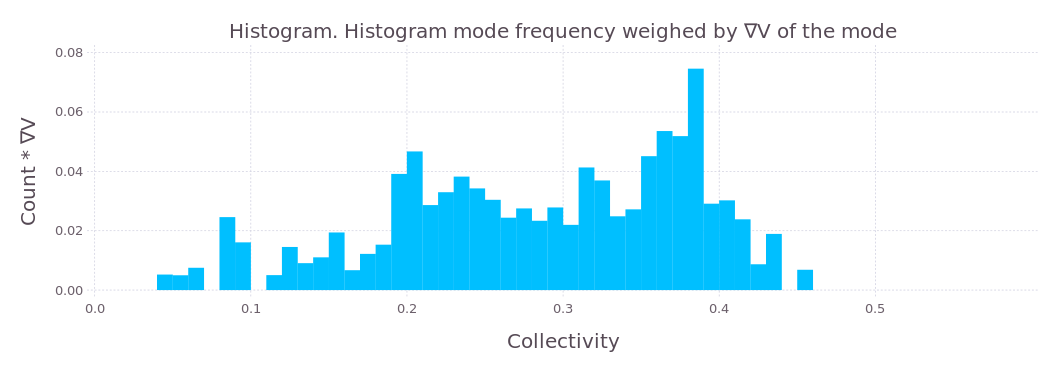

In [56]:
pdf_mode_κ_pnum_Whis = plot(df_mode_κ_pnum_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

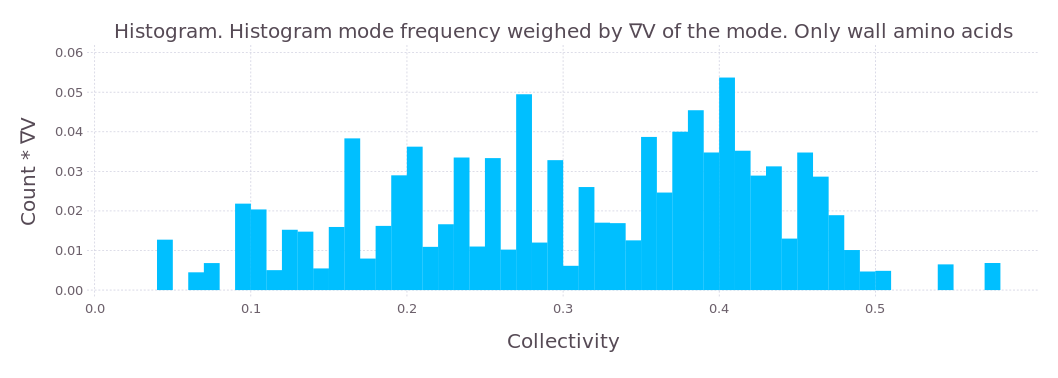

In [57]:
pdf_mode_κ_whole_pnum_Whis = plot(df_mode_κ_whole_pnum_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode. Only wall amino acids"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.6),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

### Según Pnumber

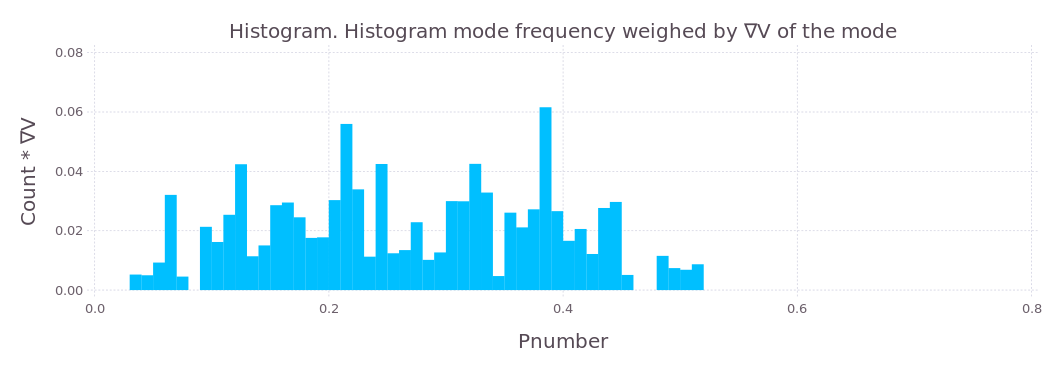

In [65]:
pdf_mode_pn_pnum_Whis = plot(df_mode_pn_pnum_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

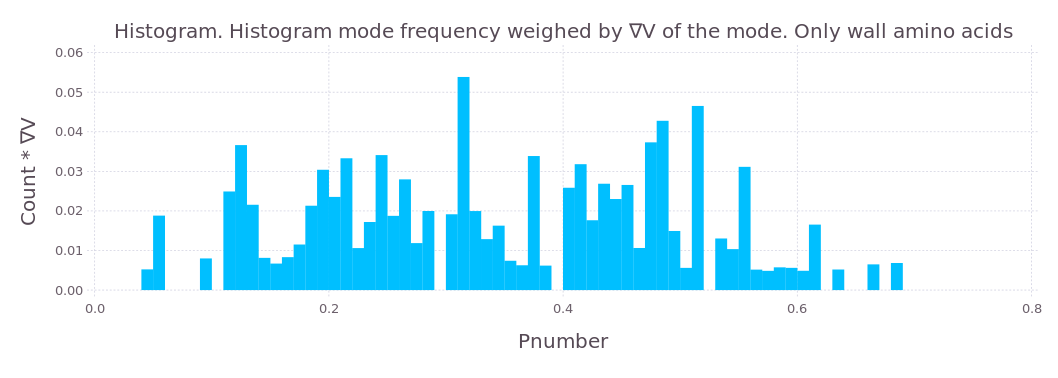

In [66]:
pdf_mode_pn_whole_pnum_Whis = plot(df_mode_pn_whole_pnum_Whis, x="Pnumber", y="Probability", Geom.bar,
Guide.title("Histogram. Histogram mode frequency weighed by ∇V of the mode. Only wall amino acids"),
Guide.ylabel("Count * ∇V"), Coord.cartesian(xmin = 0, xmax = 0.8),
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt, key_title_font_size = 50pt))

# Hay modos con frecuencia de 175  1/cm a 200 1/cm q mueven considerablemente al hueco

In [60]:
# Hago la mask p/ ir filtrando según las frecuencias de interés
mask_175_200 = 175 .< evals_prt .< 200
evals_prt_pico = evals_prt[mask_175_200]

# Me quedo con los modos en cuestión
modes_prt_pico = modes_prt[:, mask_175_200]
# Los pnumber de los susodichos modos
pnum_modes_prt_pico = pnum_modes_prt[mask_175_200]
# Redondeo
pnum_modes_prt_pico = convert(Array{Int64, 1}, round(pnum_modes_prt_pico))

# Los pnumber de los susodichos modos
pn_modes_prt_pico = pn_modes_prt[mask_175_200];

# Lista ordenada de aminoácidos más movidos por c/ modo
full_aa_pnum_each_mode = mapslices(x -> sortperm(x), mapslices(x -> tognm(x), modes_prt_pico, 1), 1);

In [157]:
aa_pnum_each_mode = Array{Int64, 1}
nres_whole_pnum_each_mode = Array{Int64, 1}(0)
i = 1
for pnum in pnum_modes_prt_pico
    # Tomo los 1eros "pnumber" aminoácidos más movidos por c/ modo
    aa_pnum_each_mode = full_aa_pnum_each_mode[1:pnum, i]
    # Me fijo cuantos de esos aminoácidos son de pared
    push!(nres_whole_pnum_each_mode, length(findin(indices_gdte_whole, aa_pnum_each_mode)))
    i = i + 1
end
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's de paredes)
pttion_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ length(indices_gdte_whole);
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's movidos por ese modo)
specificity_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ pnum_modes_prt_pico

# Ahora hago un dataframe p/ plotear
proper_labels = repeat(map(x->string(x), round(evals_prt_pico, 2)), outer=[2])
proper_labels = reshape(transpose([ map(x->string(x), round(evals_prt_pico, 2))  repeat([" "], inner=[length(evals_prt_pico)]) ]), 62)
df_pttion_whole_pnum_each_mode = DataFrame(
    Proportion = [ pttion_whole_pnum_each_mode, specificity_whole_pnum_each_mode ],
    Frequency = repeat(round(evals_prt_pico, 1), outer=[2]),
    Labels = proper_labels,
    X = repeat(collect(1:1:length(pnum_modes_prt_pico)), outer=[2]),
    Name = repeat(["Partition", "Specificity"], inner=[length(pnum_modes_prt_pico)]));

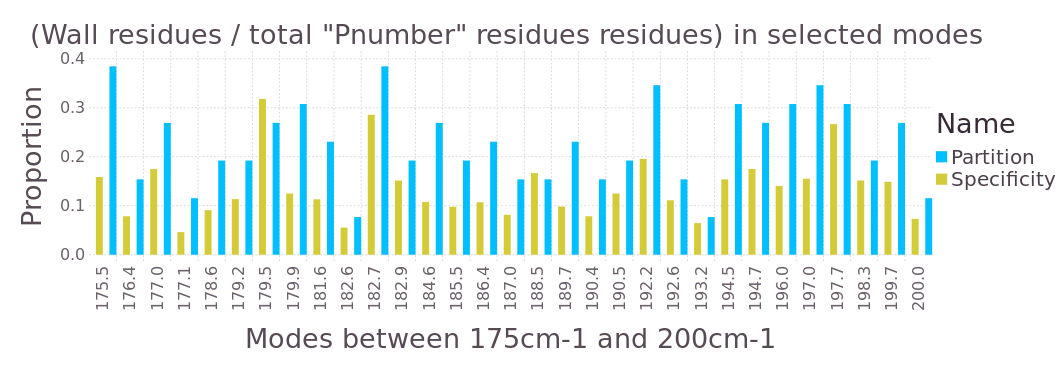

In [184]:
pdf_pttion_whole_pnum_each_mode = plot(df_pttion_whole_pnum_each_mode,
    Geom.bar(position=:dodge), y="Proportion", color = "Name",
    x = "Frequency",
    #Geom.label(), label="Labels",
    Guide.xlabel("Modes between 175cm-1 and 200cm-1"),
    Guide.title("(Wall residues / total \"Pnumber\" residues residues) in selected modes "),
    #Guide.xticks(orientation=:horizontal),
    Scale.x_discrete,
    Coord.cartesian(ymax = 0.4),
    Theme(bar_spacing=10pt,
    minor_label_font_size = 12pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
    key_label_font_size = 15pt))

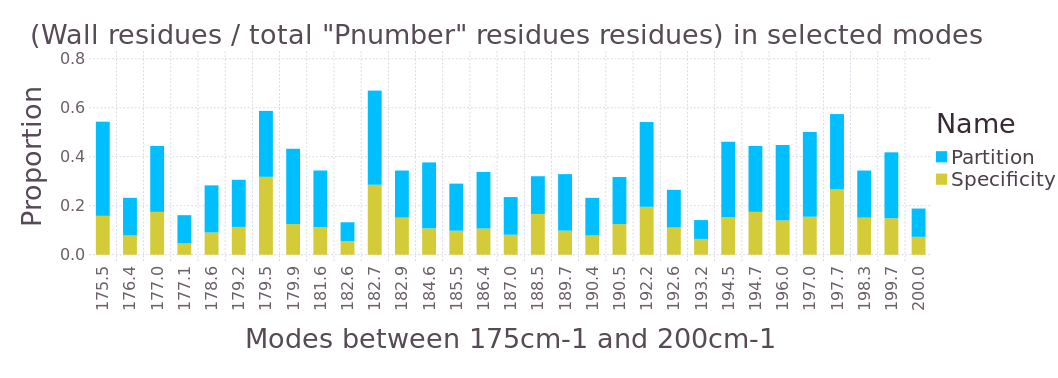

In [183]:
pdf_pttion_whole_pnum_each_mode = plot(df_pttion_whole_pnum_each_mode,
    Geom.bar(), y="Proportion", color = "Name",
    x = "Frequency",
    #Geom.label(), label="Labels",
    Guide.xlabel("Modes between 175cm-1 and 200cm-1"),
    Guide.title("(Wall residues / total \"Pnumber\" residues residues) in selected modes "),
    #Guide.xticks(orientation=:horizontal),
    Scale.x_discrete,
    Coord.cartesian(ymax = 0.8),
    Theme(bar_spacing=10pt, 
    minor_label_font_size = 12pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
    key_label_font_size = 15pt))

In [192]:
collect(1:25:maximum(evals_prt))

30-element Array{Float64,1}:
   1.0
  26.0
  51.0
  76.0
 101.0
 126.0
 151.0
 176.0
 201.0
 226.0
 251.0
 276.0
 301.0
   ⋮  
 451.0
 476.0
 501.0
 526.0
 551.0
 576.0
 601.0
 626.0
 651.0
 676.0
 701.0
 726.0

In [191]:
maximum(evals_prt)

734.16374

In [ ]:
# Hago la mask p/ ir filtrando según las frecuencias de interés
mask_175_200 = 175 .< evals_prt .< 200
evals_prt_pico = evals_prt[mask_175_200]

# Me quedo con los modos en cuestión
modes_prt_pico = modes_prt[:, mask_175_200]
# Los pnumber de los susodichos modos
pnum_modes_prt_pico = pnum_modes_prt[mask_175_200]
# Redondeo
pnum_modes_prt_pico = convert(Array{Int64, 1}, round(pnum_modes_prt_pico))

# Los pnumber de los susodichos modos
pn_modes_prt_pico = pn_modes_prt[mask_175_200];

# Lista ordenada de aminoácidos más movidos por c/ modo
full_aa_pnum_each_mode = mapslices(x -> sortperm(x), mapslices(x -> tognm(x), modes_prt_pico, 1), 1);

In [ ]:
aa_pnum_each_mode = Array{Int64, 1}
nres_whole_pnum_each_mode = Array{Int64, 1}(0)
i = 1
for pnum in pnum_modes_prt_pico
    # Tomo los 1eros "pnumber" aminoácidos más movidos por c/ modo
    aa_pnum_each_mode = full_aa_pnum_each_mode[1:pnum, i]
    # Me fijo cuantos de esos aminoácidos son de pared
    push!(nres_whole_pnum_each_mode, length(findin(indices_gdte_whole, aa_pnum_each_mode)))
    i = i + 1
end
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's de paredes)
pttion_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ length(indices_gdte_whole);
# Divido (el conteo de aa's de pared en los "pnumber" aminoácidos movidos por c/ modo) por (el nro total de
# aa's movidos por ese modo)
specificity_whole_pnum_each_mode = nres_whole_pnum_each_mode ./ pnum_modes_prt_pico

In [ ]:
pnum_modes_prt_pico

In [186]:
pttion_whole_pnum_each_mode

31-element Array{Float64,1}:
 0.384615 
 0.153846 
 0.269231 
 0.115385 
 0.192308 
 0.192308 
 0.269231 
 0.307692 
 0.230769 
 0.0769231
 0.384615 
 0.192308 
 0.269231 
 ⋮        
 0.192308 
 0.346154 
 0.153846 
 0.0769231
 0.307692 
 0.269231 
 0.307692 
 0.346154 
 0.307692 
 0.192308 
 0.269231 
 0.115385 